In [2]:
from maskrcnn_benchmark.config import cfg

import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

In [3]:
from demo.predictor import COCODemo

In [4]:
config_file = "configs/humanware_e2e_faster_rcnn_R_101_FPN_1x.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list([
    "MODEL.DEVICE", "cpu",
    "MODEL.WEIGHT", "../saved_models/r_101_batch_size=2_iter=7200.pth",
    "MODEL.MASK_ON", False,
    "MODEL.KEYPOINT_ON", False])
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [5]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [6]:
dataDir='datasets/Humanware_v1_1553272293/valid'
dataType='valid'
annFile='{}/instances_{}.json'.format(dataDir,dataType)

In [7]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
house number

COCO supercategories: 
house number


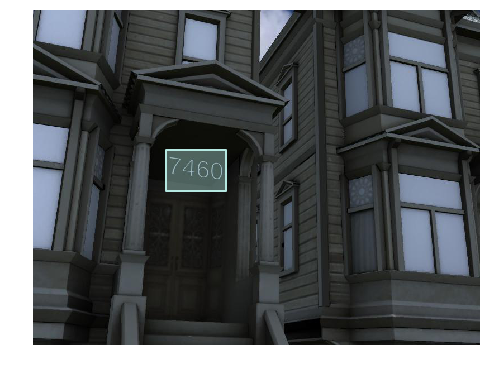

In [38]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['house number']);
imgIds = coco.getImgIds(catIds=catIds );
# imgIds = coco.getImgIds(imgIds = [500,1,200])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]


In [71]:
def compare(imgs):
    # load image
    for img in imgs:
        I = io.imread('%s/%s'%(dataDir,img['file_name']))
        # load and display instance annotations
        plt.figure()
        ax = plt.subplot(1,2,1)
        ax.imshow(I);
        ax.set_xlabel('Original')
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)

        # predict bbox
        predictions = coco_demo.compute_prediction(I)
        top_predictions = coco_demo.select_top_predictions(predictions)
        predictions = top_predictions

        #show overlay
        image = I.copy()
        overlay = I.copy()
        overlay2 = I.copy()
        labels = predictions.get_field("labels")
        boxes = predictions.bbox
        alpha = 0.5
        colors = coco_demo.compute_colors_for_labels(labels).tolist()

        for box, color in zip(boxes, colors):
            box = box.to(torch.int64)
            top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
            overlay = cv2.rectangle(
                overlay, tuple(top_left), tuple(bottom_right), tuple(color), -1
            )
#             top_left = np.array(anns[0]['bbox'][:2], dtype='int')
#             bottom_right = np.array(anns[0]['bbox'][:2], dtype='int')+np.array(anns[0]['bbox'][2:], dtype='int')
#             overlay2 = cv2.rectangle(
#                 overlay2, tuple(top_left), tuple(bottom_right), (100,2,50), -1
#             )
            cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
#             cv2.addWeighted(overlay2, alpha, image, 1 - alpha, 0, image)
        ax = plt.subplot(1,2,2)
        ax.imshow(image)
        ax.set_xlabel('Predicted')
        plt.savefig("../results/pred_"+img['file_name'])

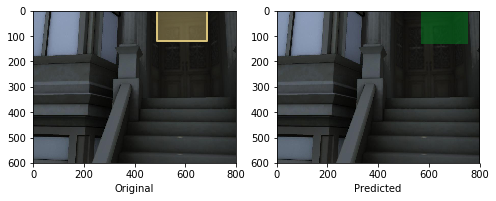

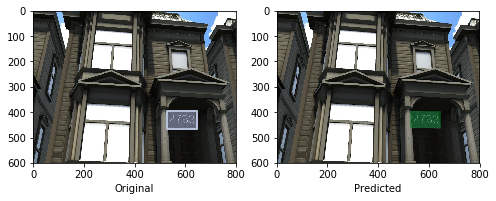

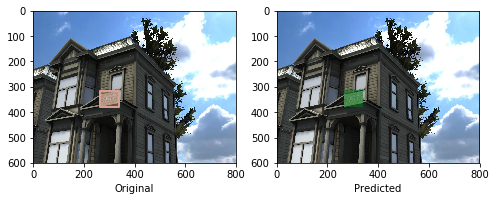

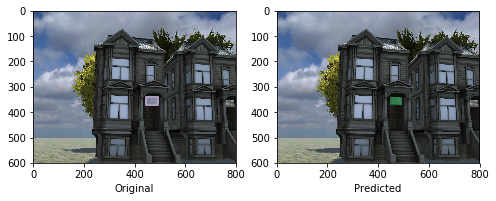

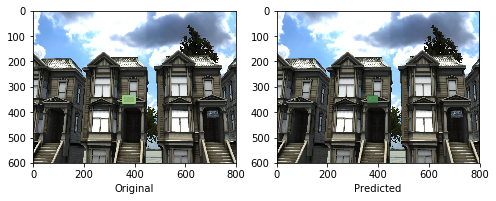

In [72]:
imgs = coco.loadImgs(np.array(imgIds)[np.random.randint(0,len(imgIds), (5,))])[:5]
compare(imgs)